In [1]:
__author__ = "Eduardo Gil González-Madroño"
__copyright__ = "Copyright 2020. Eduardo Gil"
__email__ = "eggom84@gmail.com"

# Churn Case Study

#### Customer Churn Analysis
***

## 00. Decode & Define The Business Issue

## 01. Aux stuff: import libs, global vars, global functions

#### 01.A Import libs

In [2]:
# Import Libs & settings
import pandas as pd
pd.set_option('max_columns', 105)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### 01.C Global Functions

In [3]:
def missing_values_summary(df):
    print("***************************************   missing_values_summary   **************************************\n\n")
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(4)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There is/are " + str(mis_val_table_ren_columns.shape[0]) +
          " column/s that has/have missing values:")
    
    print("\n",list(mis_val_table_ren_columns.index))
    
    return mis_val_table_ren_columns

In [4]:
def duplicate_col_values_analysis(df):
    
    print("**********************************    duplicate_col_values_analysis(df)    **********************************\n")
    print(". . . . . . . . . . . . . . . . ..            (Sensitive to NaN)           .. . . . . . . . . . . . . . . . .\n\n")
    
    cols_all_same_values = []
    cols_all_diff_values = []
    
    n_records = len(df)
    all_diff_val = 1/n_records
    
    print("1. SUMMARY OF REPEATED VALUES PER COLUMN:")
    
    for column in df:
        n_por_valor=df[column].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        
        if (mas_comun == menos_comun) and (mas_comun == 1 ):
            cols_all_diff_values.append(column)
        elif (mas_comun == menos_comun) and (mas_comun == len(df) ):
            cols_all_same_values.append(column)
        else:
            print("  For  {} the most common value appears {:.2f}% and the least common value appears {:.2f}%".format(
                column.ljust(24),
                round((mas_comun/n_records)*100,3),
                round((menos_comun/n_records)*100,3),
            ))
    print("\n")
    print("\n2. Frequency of a value appearing just once: {:.2f}%".format(round((1/n_records)*100,3)))
    print("\n3. Columns of DataFrame with ALL values DIFFERENT TO EACH OTHER \
           \n   (Possible Primary Key??--Valuable for analysis?):\n")
    print("  ",cols_all_diff_values)
    print("\n\n4. Columns of DataFrame with ALL values THE SAME \
           \n   (Valuable for analysis?):\n")
    print("  ",cols_all_same_values)
    
    return cols_all_diff_values, cols_all_same_values

In [5]:
def view_duplicate_row_values(df):
    
    print("**********************************    view_duplicate_row_values   **********************************")
    
    df_col_labels = list(df.columns)
    cols_all_diff_values = []
    cols_non_idx = []
    
    for column in df:
        n_por_valor=df[column].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        
        if (mas_comun == menos_comun) and (mas_comun == 1 ):
            cols_all_diff_values.append(column)
    
    cols_non_idx = [col for col in df_col_labels if col not in cols_all_diff_values]
    
    r_df = df[df.duplicated(cols_non_idx, keep=False)]
    
    return r_df

In [6]:
from scipy import stats
import numpy as np

def view_outliers_per_col(df, z_score=3):
    
    print("******************************************   view_outliers_per_col   *****************************************\n\n")
    
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna]))>z_score])
            print("For feature {} the number of outliers is: {} and proportion over all observations is: {}%".format(
                columna.ljust(24),
                n_outliers,
                round((n_outliers / len(df[columna]))*100,4)
            ))

In [62]:
def skew_kurto_table_and_plot(df,pct_feat_selection = 100):
    
    # Selecting the numerical data:
    
    df_num_labels = df.select_dtypes(np.number).columns
    
    # Building the table and then dataframe:
    
    skew_list = []
    kurt_list = []
    max_list = []
    min_list = []
    range_list = []
    labels = []
    
    for col in df_num_labels:
        labels.append(col)
        skew_list.append(df[col].skew())
        kurt_list.append(df[col].kurt())
        max_list.append(df[col].max())
        min_list.append(df[col].min())
        range_list.append(df[col].max()-df[col].min())
    
    global_list = [labels,skew_list,kurt_list,max_list,min_list,range_list]

    df_return = pd.DataFrame(global_list).T
    df_return = df_return.rename(columns = {0 : 'feature', 1 : 'skewness', 2 : 'kurtosis', 3 : 'max_val', 4 : 'min_val', 5 : 'range'})

    df_return = df_return.sort_values(by="skewness", ascending=False)
    
    nb_of_feat = round(len(df_return)*(pct_feat_selection/100))
    
    print("Number of Features on table: ",nb_of_feat)
    
    # Plotting the KDE of the selected features:
    
    total_plots = len(df_return.set_index("feature").head(nb_of_feat))
    
    some_empty_plot = False
    overflow = False
    subplot_dist = [1,1]
    figsize = (4,5)
    
    if total_plots%2==1:
        total_plots += 1
        some_empty_plot = True

    if total_plots == 2:
        subplot_dist = [2,1]
        figsize = (4,7)
    elif total_plots == 4:
        subplot_dist = [2,2]
        figsize = (8,7)
    elif total_plots == 6:
        subplot_dist = [2,3]
        figsize = (12,7)
    elif total_plots == 8:
        subplot_dist = [2,4]
        figsize = (16,7)
    elif total_plots == 10:
        subplot_dist = [3,4]
        figsize = (16,10)
    elif total_plots == 12:
        subplot_dist = [3,4]
        figsize = (16,10)
    elif total_plots == 14:
        subplot_dist = [4,4]
        figsize = (16,12)
    elif total_plots == 16:
        subplot_dist = [4,4]
        figsize = (16,12)
    elif total_plots == 18:
        subplot_dist = [5,4]
        figsize = (16,16)
    elif total_plots == 20:
        subplot_dist = [5,4]
        figsize = (16,16)
    elif total_plots == 22:
        subplot_dist = [5,5]
        figsize = (16,16)
    elif total_plots == 24:
        subplot_dist = [5,5]
        figsize = (16,16)
    elif total_plots == 26:
        subplot_dist = [6,5]
        figsize = (16,18)
    elif total_plots == 28:
        subplot_dist = [6,5]
        figsize = (16,18)
    elif total_plots == 30:
        subplot_dist = [6,5]
        figsize = (16,18)
    else:
        overflow = True
        some_empty_plot = True

    fig, axs = plt.subplots(subplot_dist[0],subplot_dist[1], figsize=figsize)
    # axs is a 2D array with shape (6,5)
    # you can keep track of counters in your for-loop to place the resulting graphs
    # using ax=axs[i,j]
    # or an alternative is to use a generator that you can use to get the next axes
    # instance at every step of the loop
    
    row = 0
    
    for i in range(subplot_dist[0]):
        for j in range(subplot_dist[1]):
            if some_empty_plot == False:
                sns.distplot(df[df_return.set_index("feature").head(nb_of_feat).index[row]], ax=axs[i,j])
                row += 1
            else:
                if overflow == True:
                    print("\nToo many features to be plotted. Max is 30!. Table will be still available.\n")
                    break
                if row<nb_of_feat:
                    sns.distplot(df[df_return.set_index("feature").head(nb_of_feat).index[row]], ax=axs[i,j])
                    row += 1                    
                    
    return df_return.set_index("feature").head(nb_of_feat)

In [271]:
from ipywidgets import interact, fixed
def interactive_kde(df,numeric_cols):
    df[numeric_cols].plot.kde();
    plt.xlabel("Distribución de la variable {}".format(numeric_cols))
    plt.show()

In [272]:
def view_rows_with_nan(df, where = 'any'):

    print("******************************************   view_rows_with_nan   *****************************************\n\n")
    
    if (where != 'any') and (where != 'all'):
        where = 'any'
        print("\nIncorrect value for 'where' passed to the function. Set 'any' as default.")
    
    if where == 'any':
        r_df = df[df.isnull().any(axis=1)]
        print("\n· Row IDs  with at least 1 NaN value:    ",list(r_df.index))
        print("\n· Nb. of rows with at least 1 NaN value: ",len(list(r_df.index)))
        print("\n")
        
        for row in list(r_df.index):
            print("Row  {} has a total of {} NaN values".format(
                str(row).ljust(4),
                str(df.iloc[row].isnull().sum()).ljust(3)
            ))
            
    if where == 'all':
        r_df = df[df.isnull().all(axis=1)]
        print("\n· Row IDs with all values on row = NaN:     ",list(r_df.index))
        print("\n· Nb. of rows with all values on row = NaN: ",len(list(r_df.index)))
        
    return r_df

## 02. Get The Data -- Data Mining

In [99]:
w_df = pd.read_csv('./data/Churn_Modelling.csv')
w_df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## 03. Know The Data -- Data Learning

The dataset is formed by the following number of features:

* **RowNumber:** The number of the row.
* **CustomerID:** The unique customer id
* **Surname:** The customer´s surname
* **CreditScore:** The customer´s credit score
* **Geography:** Where the customer is based
* **Gender:** The customer´s gender
* **Age:** The customer´s age (in years)
* **Tenure:** The time of bond with company (in years)
* **Balance:** The amount left with them??
* **NumOfProducts:** The number of products acquired
* **HasCrCard:** Whether customer has Credit Card or not (1: Yes  0: No)
* **IsActiveMember:** Whether customer is an active member of the platform or not(1: Yes  0: No)
* **EstimatedSalary:** Customer's estimated salary (in USD)

And the following target feature:

* **Exited** Customer´s who left in the last year (1: Left  0: Stay)

## 04. Prepare The Data -- Data Cleaning

#### 04.A Exploring missing values in the dataset

In [100]:
missing_values_summary(w_df)

***************************************   missing_values_summary   **************************************


Your selected dataframe has 14 columns.
There is/are 0 column/s that has/have missing values:

 []


,Missing Values,% of Total Values


#### 04.B Detecting duplicate data

In [101]:
duplicate_col_values_analysis(w_df)

**********************************    duplicate_col_values_analysis(df)    **********************************

. . . . . . . . . . . . . . . . ..            (Sensitive to NaN)           .. . . . . . . . . . . . . . . . .


1. SUMMARY OF REPEATED VALUES PER COLUMN:
  For  Surname                  the most common value appears 0.32% and the least common value appears 0.01%
  For  CreditScore              the most common value appears 2.33% and the least common value appears 0.01%
  For  Geography                the most common value appears 50.14% and the least common value appears 24.77%
  For  Gender                   the most common value appears 54.57% and the least common value appears 45.43%
  For  Age                      the most common value appears 4.78% and the least common value appears 0.01%
  For  Tenure                   the most common value appears 10.48% and the least common value appears 4.13%
  For  Balance                  the most common value appears 36.17% and the

(['RowNumber', 'CustomerId'], [])

From the summary just above it can be seen that columns 'RowNumber' and 'CustomerId' may act as primary keys. *In that case, are they actually useful?*

Columns like those ones or the ones with all values the same are not really useful in our analysis so the decision will be to delete them from the working dataset.

As well the column 'Surname' will be dropped as it is kind of irrelevant for our analysis.

In [102]:
feats_to_drop = ['RowNumber', 'CustomerId', 'Surname']

In [103]:
w_df = w_df.drop(feats_to_drop, axis=1)

In [104]:
view_duplicate_row_values(w_df)

**********************************    view_duplicate_row_values   **********************************


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


After confirming that all data is genuinely belonging to different customers and no missing values are present, let´s export this data into a new dataset.

In [105]:
w_df.to_csv('./data/Churn_Modelling_stg1.csv')

#### 04.C Unwanted Outliers

In [106]:
view_outliers_per_col(w_df)

******************************************   view_outliers_per_col   *****************************************


For feature CreditScore              the number of outliers is: 8 and proportion over all observations is: 0.08%
For feature Age                      the number of outliers is: 133 and proportion over all observations is: 1.33%
For feature Tenure                   the number of outliers is: 0 and proportion over all observations is: 0.0%
For feature Balance                  the number of outliers is: 0 and proportion over all observations is: 0.0%
For feature NumOfProducts            the number of outliers is: 60 and proportion over all observations is: 0.6%
For feature HasCrCard                the number of outliers is: 0 and proportion over all observations is: 0.0%
For feature IsActiveMember           the number of outliers is: 0 and proportion over all observations is: 0.0%
For feature EstimatedSalary          the number of outliers is: 0 and proportion over all observat

Before going into elimination of outliers I am going to start some data exploration.

## 05. Explore The Data -- EDA (Exploratory Data Analysis)

### 05.A Some Data Simple Inspection

In [107]:
# Dataset Shape
w_df.shape

(10000, 11)

0    7963
1    2037
Name: Exited, dtype: int64


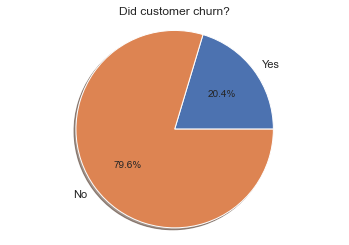

In [108]:
# Dataset Target Feature Balance
print(w_df.Exited.value_counts())

labels = ["Yes","No"]
sizes = [w_df.Exited.value_counts()[1],w_df.Exited.value_counts()[0]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title("Did customer churn?")
plt.show()


The dataset, as predicted, **is very imbalanced**:

A bit over 20% customers churn.

In [109]:
# Features Data Types
w_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [110]:
# Summary Statistics for numerical columns
w_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 05.B Some Data Simple Visualization

In [111]:
# Quantitative Features of the dataset
num_feats = w_df.select_dtypes(np.number)

In [112]:
# Quanlitative Features of the dataset
cat_feats = w_df.select_dtypes(["object","category","bool"])

In [113]:
interact(interactive_kde, numeric_cols=num_feats, df=fixed(w_df));

interactive(children=(Dropdown(description='numeric_cols', options=('CreditScore', 'Age', 'Tenure', 'Balance',…

Number of Features on table:  4


,skewness,kurtosis,max_val,min_val,range
feature,,,,,
Age,1.01132,1.39535,92,18,74
EstimatedSalary,0.00208536,-1.18152,199992,11.58,199981
CreditScore,-0.0716066,-0.425726,850,350,500
Balance,-0.141109,-1.48941,250898,0,250898


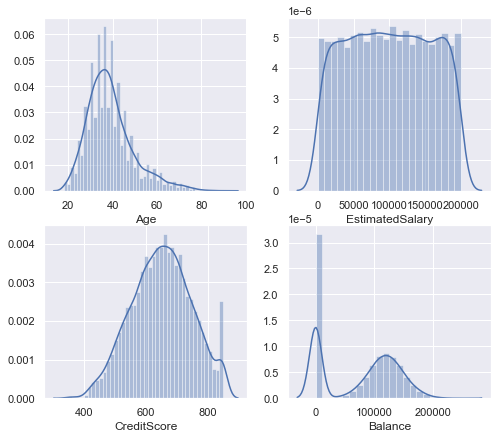

In [114]:
skew_kurto_table_and_plot(w_df[["Age", "EstimatedSalary", "CreditScore", "Balance"]])

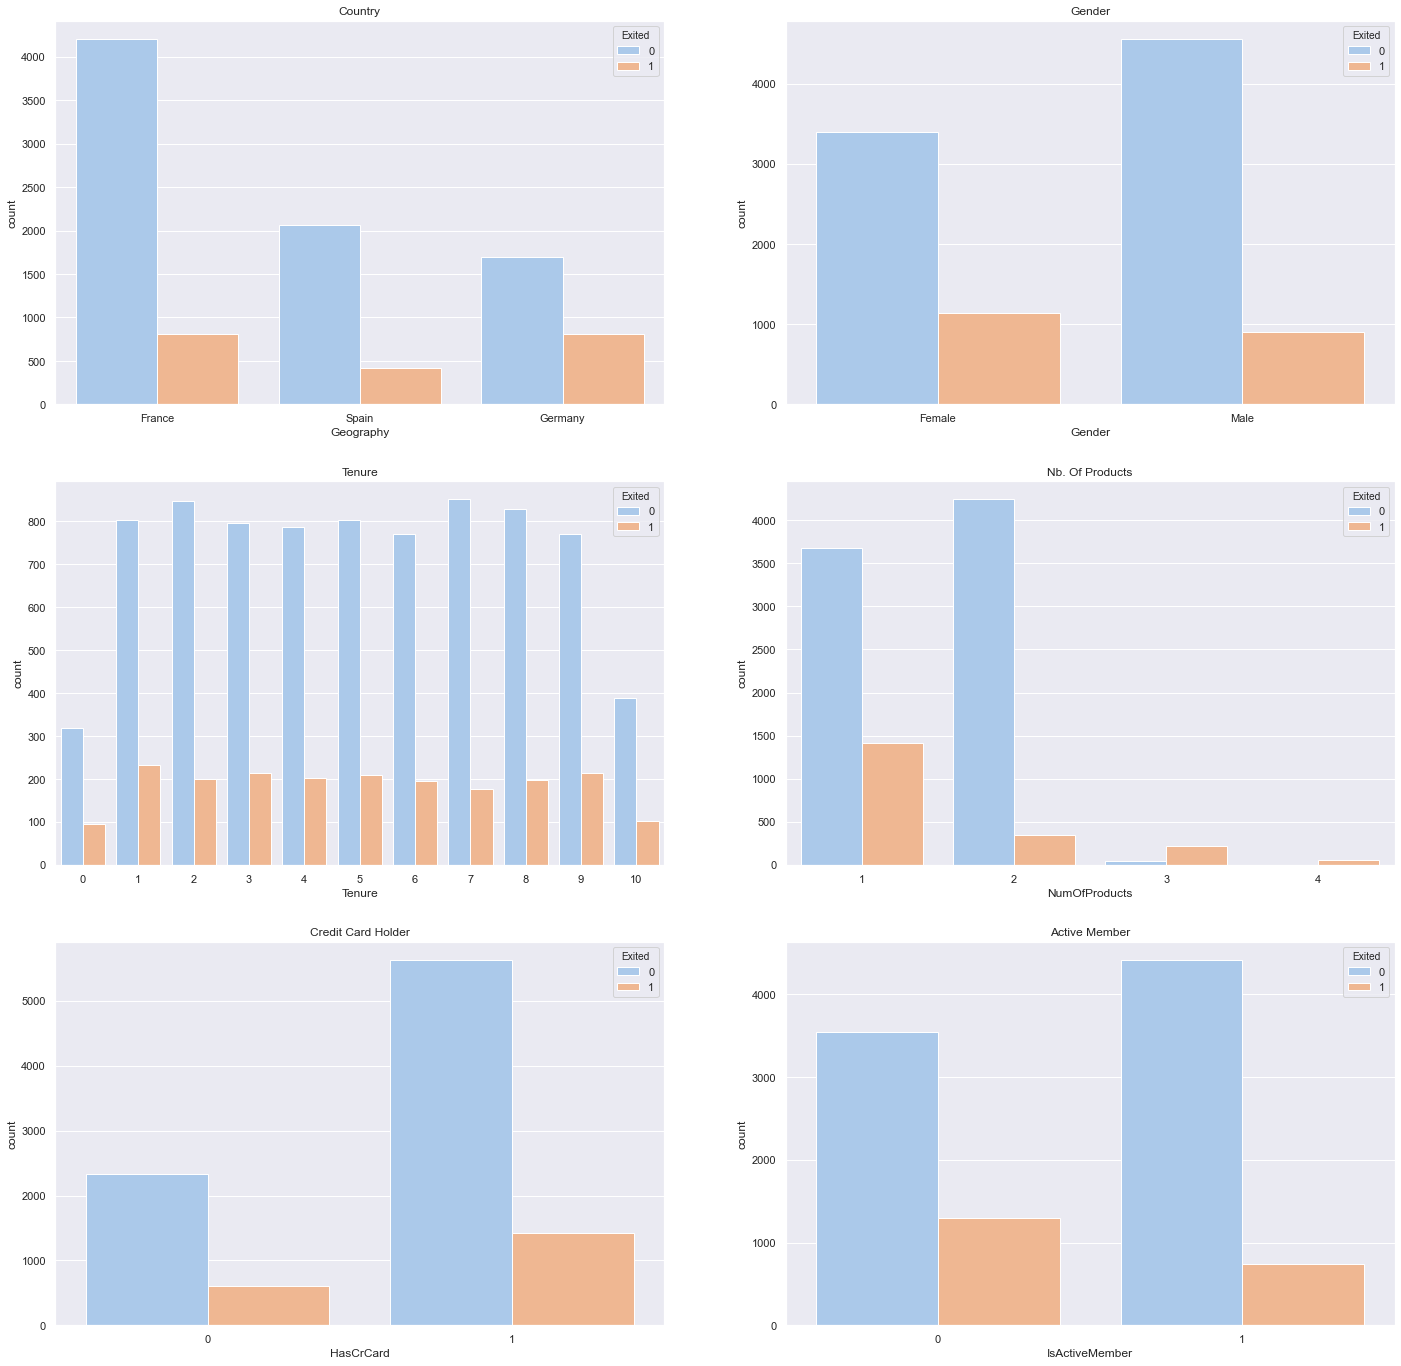

In [115]:
plt.figure(figsize=(24,24))

plt.subplot(3,2,1)
sns.countplot(x='Geography', hue='Exited', data=w_df, palette='pastel');
plt.title('Country')

plt.subplot(3,2,2)
sns.countplot(x='Gender', hue='Exited', data=w_df, palette='pastel');
plt.title('Gender')

plt.subplot(3,2,3)
sns.countplot(x='Tenure', hue='Exited', data=w_df, palette='pastel');
plt.title('Tenure')

plt.subplot(3,2,4)
sns.countplot(x='NumOfProducts', hue='Exited', data=w_df, palette='pastel');
plt.title('Nb. Of Products')

plt.subplot(3,2,5)
sns.countplot(x='HasCrCard', hue='Exited', data=w_df, palette='pastel');
plt.title('Credit Card Holder')

plt.subplot(3,2,6)
sns.countplot(x='IsActiveMember', hue='Exited', data=w_df, palette='pastel');
plt.title('Active Member');

Some of the insights thrown by this visualization:

* German customers are more likely to leave compared to the other countries.
* Females customers are more likely to leave compared to male ones.
* Customers with number of products equalling 4 are churning 100% of the times.
* Customers with number of products equalling 3 are churning almost 100% of the time.
* The ratio of customers churning when they are active members is much lower if compared to the non active memebers (as expected).

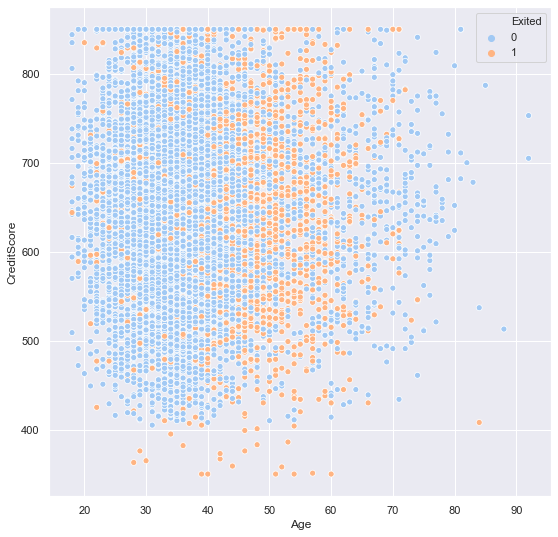

In [116]:
plt.figure(figsize=(9,9))
sns.scatterplot(w_df['Age'],w_df['CreditScore'],hue=w_df['Exited'],palette='pastel')
plt.show()

Majority of exited customers lies between the age of 45 to 65.

In [143]:
w_df.groupby(["Geography"]).mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,yrs_tenure_pct
Geography,,,,,,,,,,
France,649.905788,38.503593,5.004790,62094.337914,1.531337,0.706587,0.516766,99867.384379,0.160878,0.138865
Germany,651.693658,39.765058,5.012365,119716.785688,1.519745,0.714001,0.497806,101077.137962,0.323893,0.134382
Spain,651.574141,38.879596,5.032727,61748.417038,1.538990,0.694545,0.529697,99386.006036,0.166061,0.139850


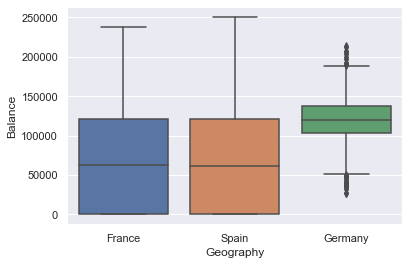

In [144]:
sns.boxplot( x=w_df["Geography"], y=w_df["Balance"] )

None of the German customers have Balance of 0.

Now it is time to have a look at the outliers:

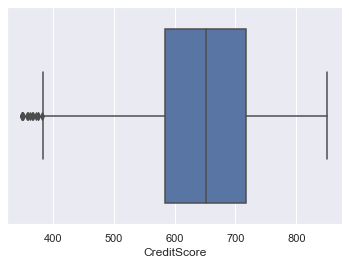

In [117]:
sns.boxplot(x=w_df["CreditScore"])

In [118]:
w_df.sort_values("CreditScore")[:8]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8762,350,France,Female,60,3,0.00,1,0,0,113796.15,1
8723,350,France,Male,51,10,0.00,1,1,1,125823.79,1
1838,350,Germany,Male,39,0,109733.20,2,0,0,123602.11,1
9624,350,France,Female,40,0,111098.85,1,1,1,172321.21,1
1631,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1
2473,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1
1962,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1
1405,359,France,Female,44,6,128747.69,1,1,0,146955.71,1


Drop the outliers ---> All rows with CreditScore <= 359:

In [119]:
w_df = w_df[w_df["CreditScore"]>359]

In [120]:
# Export this new dataset:
w_df.to_csv('./data/Churn_Modelling_stg2.csv')

## 06. Feature Engineering

#### Creating some new "meaningful" features:

In [321]:
w_df["yrs_tenure_pct"] = w_df["Tenure"] / w_df["Age"]

Number of Features on table:  4


,skewness,kurtosis,max_val,min_val,range
feature,,,,,
Age,1.01324,1.40252,92,18,74
yrs_tenure_pct,0.56612,-0.0448444,0.555556,0,0.555556
Tenure,0.0108874,-1.16525,10,0,10
Balance,-0.140589,-1.48936,250898,0,250898


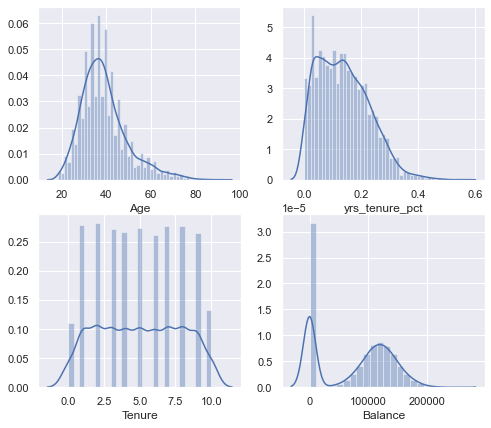

In [322]:
skew_kurto_table_and_plot(w_df[["Age", "Tenure", "yrs_tenure_pct", "Balance"]])

## 06. Data Preprocessing -- Transformers

#### 06.A One Hot Encoding (Get Dummies)

In [323]:
cat_feats = ["Geography","Gender"]
cat_df = pd.get_dummies(w_df[cat_feats], drop_first=True)

In [324]:
# DataFrame Concatenation and cat features dropping
w_df_only_dummies = pd.concat([cat_df,w_df], axis=1)
w_df_only_dummies = w_df_only_dummies.drop(["Geography","Gender"], axis=1)

In [325]:
# Export this new dataset:
w_df_only_dummies.to_csv('./data/Churn_Modelling_stg3_dummies_no_scaling.csv')

#### 06.B Standard Scaling the Data

In [331]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
num_df_values = sc.fit_transform(w_df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'yrs_tenure_pct']])

In [332]:
num_df = pd.DataFrame(num_df_values, columns=['CreditScore',
                                              'Age',
                                              'Tenure',
                                              'Balance',
                                              'NumOfProducts',                                             
                                              'EstimatedSalary',
                                              'yrs_tenure_pct'])

In [337]:
w_df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,yrs_tenure_pct
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390


In [338]:
num_df.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,yrs_tenure_pct
0,-0.329821,0.294397,-1.042285,-1.225585,-0.911981,0.022556,-1.009680
1,-0.444026,0.199023,-1.388144,0.117671,-0.911981,0.217196,-1.269223


In [339]:
cat_df.head(2)

,Geography_Germany,Geography_Spain,Gender_Male
0,0,0,0
1,0,1,0


In [340]:
w_df[["HasCrCard","IsActiveMember","Exited"]].head(2)

,HasCrCard,IsActiveMember,Exited
0,1,1,1
1,0,1,0


In [341]:
print(num_df.shape)
print(cat_df.shape)
print(w_df[["HasCrCard","IsActiveMember","Exited"]].shape)

(9992, 7)
(9992, 3)
(9992, 3)


In [342]:
(num_df.index == cat_df.index).sum()

9992

In [343]:
w_df_dummies_and_stdscaling = pd.concat([cat_df,num_df,w_df[["HasCrCard","IsActiveMember","Exited"]]], axis=1)

In [344]:
w_df_dummies_and_stdscaling.shape

(9992, 13)

In [345]:
# Export this new dataset:
w_df_dummies_and_stdscaling.to_csv('./data/Churn_Modelling_stg3_dummies_and_stdscaling.csv')

## 06. Select Best Data -- Feature Selection / Engineering

#### 06.A Feature Selection

Using SelectKBest to get the features

In [347]:
w_df = w_df_dummies_and_stdscaling.copy()

In [368]:
X_pred = w_df.drop("Exited", axis=1)
X_pred.head(2)

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,yrs_tenure_pct,HasCrCard,IsActiveMember
0,0,0,0,-0.329821,0.294397,-1.042285,-1.225585,-0.911981,0.022556,-1.009680,1,1
1,0,1,0,-0.444026,0.199023,-1.388144,0.117671,-0.911981,0.217196,-1.269223,0,1


In [369]:
y_target = w_df["Exited"]
y_target.head(2)

0    1
1    0
Name: Exited, dtype: int64

In [370]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_pred,y_target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_pred.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 5best features

ValueError: Input X must be non-negative.

## 07. Train/Test Split

In [371]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(X_pred,y_target,test_size=0.20, random_state=12)

In [372]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7993, 12)
(1999, 12)
(7993,)
(1999,)


## 09. Data Resampling

### (To Tackle imbalanced datasets)

In [373]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)

Original shape: (7993, 12) (7993,)
Upsampled shape: (12742, 12) (12742,)


In [378]:
# Upsample using SMOTE
sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)

Original shape: (7993, 12) (7993,)
Upsampled shape: (12742, 12) (12742,)
SMOTE sample shape: (12742, 12) (12742,)


In [380]:
# Upsample using SMOTE Tomek
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
x_train_smt, y_train_smt = sm.fit_sample(X_train, y_train)

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print ("SMOTE Tomek sample shape:", x_train_smt.shape, y_train_smt.shape)

Original shape: (7993, 12) (7993,)
Upsampled shape: (12742, 12) (12742,)
SMOTE sample shape: (12742, 12) (12742,)
SMOTE Tomek sample shape: (12742, 12) (12742,)


In [381]:
# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print ("SMOTE Tomek sample shape:", x_train_smt.shape, y_train_smt.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (7993, 12) (7993,)
Upsampled shape: (12742, 12) (12742,)
SMOTE sample shape: (12742, 12) (12742,)
SMOTE Tomek sample shape: (12742, 12) (12742,)
Downsampled shape: (3244, 12) (3244,)


# Choose Which Sampling Technique to Use For Model
***

In [382]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "SMOTE Tomek":(x_train_smt, y_train_smt),
                "Downsampled": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring='f1').mean()

The best F1 Score for Original data:
0.3174934712233661
The best F1 Score for Upsampled data:
0.70369531379975
The best F1 Score for SMOTE data:
0.731749148499801
The best F1 Score for SMOTE Tomek data:
0.731749148499801
The best F1 Score for Downsampled data:
0.7054148926606884


0.49427841090751184

By looking at the F1 Scores it looks like the best option is SMOTE!

## 10. Machine Learning Modelling

Will be using few modelling techniques:

* Logistic Regression
* Naives-Bayes Classifier
* Decision Tree
* Random Forest Classifier
* Extra Trees Classifier
* SVM
* XGBClassifier
* ANN

In [399]:
bool_feats = ['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'HasCrCard', 'IsActiveMember']
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'yrs_tenure_pct']

### Logistic Regression

In [400]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

# Fit the model to the Upsampling data
lr = lr.fit(x_train_sm, y_train_sm)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

print(classification_report(y_test, lr.predict(X_test)))



 ---Logistic Regression Model---
Logistic Regression AUC = 0.69
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1592
           1       0.38      0.64      0.48       407

    accuracy                           0.72      1999
   macro avg       0.64      0.69      0.64      1999
weighted avg       0.79      0.72      0.74      1999



In [402]:
print('Accuracy on training set:',lr.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',lr.score(X_test,y_test))

Accuracy on training set: 0.7354418458640716
Accuracy on test set: 0.7178589294647324


### Naives-Bayes Classifier

In [404]:
from sklearn.naive_bayes import GaussianNB

nb= GaussianNB()
nb.fit(x_train_sm, y_train_sm)

print ("\n\n ---Naives Bayes Regression Model---")
nb_auc = roc_auc_score(y_test, nb.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

print(classification_report(y_test, nb.predict(X_test)))



 ---Naives Bayes Regression Model---
Logistic Regression AUC = 0.69
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1592
           1       0.37      0.63      0.47       407

    accuracy                           0.71      1999
   macro avg       0.63      0.68      0.64      1999
weighted avg       0.78      0.71      0.73      1999



In [405]:
print('Accuracy on training set:',nb.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',nb.score(X_test,y_test))

Accuracy on training set: 0.7382671480144405
Accuracy on test set: 0.7098549274637319


### Decision Tree Classifier

In [407]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt = DecisionTreeClassifier()

# Fit the model to the Upsampling data
dt.fit(x_train_sm, y_train_sm)

print ("\n\n ---Decision Tree Clf Model---")
dt_auc = roc_auc_score(y_test, dt.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

print(classification_report(y_test, dt.predict(X_test)))



 ---Decision Tree Clf Model---
Logistic Regression AUC = 0.69
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1592
           1       0.43      0.51      0.47       407

    accuracy                           0.76      1999
   macro avg       0.65      0.67      0.66      1999
weighted avg       0.78      0.76      0.77      1999



In [408]:
print('Accuracy on training set:',dt.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',dt.score(X_test,y_test))

Accuracy on training set: 1.0
Accuracy on test set: 0.759879939969985


### Random Forest Classifier

Notice how the random forest classifier takes a while to run on the dataset. That is one downside to the algorithm, it takes a lot of computation. But it has a better performance than the sipler models like Logistic Regression

In [413]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf = RandomForestClassifier(n_estimators = 500)

rf_result = cross_val_score(rf, x_train_sm, y_train_sm, cv=5, scoring='f1')

rf_result.mean()

0.8977045391731577

In [414]:
from sklearn.metrics import roc_auc_score

rf = rf.fit(x_train_sm, y_train_sm)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.73
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1592
           1       0.60      0.56      0.58       407

    accuracy                           0.83      1999
   macro avg       0.75      0.73      0.74      1999
weighted avg       0.83      0.83      0.83      1999



In [415]:
print('Accuracy on training set:',rf.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',rf.score(X_test,y_test))

Accuracy on training set: 1.0
Accuracy on test set: 0.8349174587293647


### Gradient Boosting Classifier

In [416]:
from sklearn.ensemble import GradientBoostingClassifier

In [419]:
gbc = GradientBoostingClassifier(n_estimators = 500)  

gbc = gbc.fit(x_train_sm,y_train_sm)

gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [420]:
gbc_result = cross_val_score(gbc, x_train_sm, y_train_sm, cv=5, scoring='f1')
gbc_result.mean()

0.8677486125717492

In [421]:
from sklearn.metrics import roc_auc_score

print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.74
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1592
           1       0.67      0.55      0.60       407

    accuracy                           0.85      1999
   macro avg       0.78      0.74      0.76      1999
weighted avg       0.85      0.85      0.85      1999



In [430]:
print('Accuracy on training set:',gbc.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',gbc.score(X_test,y_test))

Accuracy on training set: 0.9230105164024486
Accuracy on test set: 0.8534267133566783


### XGB Classifier

In [432]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators = 500)

xgbc = xgbc.fit(x_train_sm,y_train_sm)

xgbc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [433]:
xgbc_result = cross_val_score(xgbc, x_train_sm, y_train_sm, cv=5, scoring='f1')
xgbc_result.mean()

0.8695985613282419

In [434]:
from sklearn.metrics import roc_auc_score

print ("\n\n ---Gradient Boosting Model---")
xgbc_auc = roc_auc_score(y_test, xgbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % xgbc_auc)
print(classification_report(y_test, xgbc.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.71
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1592
           1       0.62      0.49      0.55       407

    accuracy                           0.83      1999
   macro avg       0.75      0.71      0.72      1999
weighted avg       0.82      0.83      0.83      1999



In [435]:
print('Accuracy on training set:',xgbc.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',xgbc.score(X_test,y_test))

Accuracy on training set: 1.0
Accuracy on test set: 0.8344172086043021


### Using Ensembles

### Ensemble of Log. Regression and Decision Trees

In [436]:
from sklearn.ensemble import VotingClassifier

In [437]:
voting_clf = VotingClassifier(
 estimators=[('lr', lr), ('nb', nb), ('rf', rf), ('gbc', gbc)],
 voting='hard')

In [438]:
voting_clf.fit(x_train_sm, y_train_sm)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('rf',
                              RandomForestClassifie...
                                                         max_leaf_nodes=None,
        

In [439]:
voting_clf_result = cross_val_score(voting_clf, x_train_sm, y_train_sm, cv=5, scoring='f1')
voting_clf_result.mean()

0.8285410023561557

In [441]:
print ("\n\n ---Gradient Boosting Model---")
voting_clf_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % xgbc_auc)
print(classification_report(y_test, voting_clf.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.71
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1592
           1       0.61      0.52      0.56       407

    accuracy                           0.83      1999
   macro avg       0.75      0.72      0.73      1999
weighted avg       0.83      0.83      0.83      1999



In [443]:
print('Accuracy on training set:',voting_clf.score(x_train_sm,y_train_sm))
print('Accuracy on test set:',voting_clf.score(X_test,y_test))

Accuracy on training set: 0.8800031392246115
Accuracy on test set: 0.8344172086043021


### Creating several datasets to improve accuracy...

In [453]:
w_df = pd.read_csv("./data/Churn_Modelling_stg3_dummies_no_scaling.csv")

In [456]:
w_df = w_df.drop("Unnamed: 0", axis=1)

Now we have w_df the following way:

In [576]:
w_df.sample(2)

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,yrs_tenure_pct
8479,0,0,0,802,60,3,92887.06,1,1,0,39473.63,1,0.050000
5775,1,0,0,604,42,10,166031.45,1,1,0,98293.14,0,0.238095


In [577]:
w_df_NumOfProducts_Is_4 = w_df[w_df["NumOfProducts"]==4]

In [578]:
w_df_NumOfProducts_Is_Not_4 = w_df.drop(list(w_df_NumOfProducts_Is_4.index))

In [579]:
w_df_NumOfProducts_Is_Not_4_Balance_Is_0 = w_df_NumOfProducts_Is_Not_4[w_df_NumOfProducts_Is_Not_4["Balance"]==0]

In [580]:
w_df_NumOfProducts_Is_Not_4_Balance_Is_Not_0 = w_df_NumOfProducts_Is_Not_4.drop(list(w_df_NumOfProducts_Is_Not_4_Balance_Is_0.index))

In [581]:
X_train, X_test, y_train, y_test = train_test_split(w_df.drop("Exited", axis=1),w_df["Exited"],test_size=0.20, random_state=42)

In [582]:
X_train_NumOfProducts_Is_4 = X_train[X_train["NumOfProducts"]==4]

In [583]:
y_train_NumOfProducts_Is_4 = y_train[X_train_NumOfProducts_Is_4.index]

In [584]:
X_test_NumOfProducts_Is_4 = X_test[X_test["NumOfProducts"]==4]

In [585]:
y_test_NumOfProducts_Is_4 = y_test[X_test_NumOfProducts_Is_4.index]

In [586]:
y_guess_NumOfProducts_Is_4 = pd.Series([1]*17)

In [587]:
X_train_NumOfProducts_Is_Not_4 = X_train.drop(X_train_NumOfProducts_Is_4.index)

In [588]:
y_train_NumOfProducts_Is_Not_4 = y_train[X_train_NumOfProducts_Is_Not_4.index]

In [589]:
X_test_NumOfProducts_Is_Not_4 = X_test.drop(X_test_NumOfProducts_Is_4.index)

In [590]:
y_test_NumOfProducts_Is_Not_4 = y_test[X_test_NumOfProducts_Is_Not_4.index]

In [591]:
X_train_NumOfProducts_Is_Not_4_Balance_Is_0 = X_train_NumOfProducts_Is_Not_4[X_train_NumOfProducts_Is_Not_4["Balance"]==0]

In [592]:
y_train_NumOfProducts_Is_Not_4_Balance_Is_0 = y_train_NumOfProducts_Is_Not_4[X_train_NumOfProducts_Is_Not_4_Balance_Is_0.index]

In [593]:
X_test_NumOfProducts_Is_Not_4_Balance_Is_0 = X_test_NumOfProducts_Is_Not_4[X_test_NumOfProducts_Is_Not_4["Balance"]==0]

In [594]:
y_test_NumOfProducts_Is_Not_4_Balance_Is_0 = y_test_NumOfProducts_Is_Not_4[X_test_NumOfProducts_Is_Not_4_Balance_Is_0.index]

In [595]:
X_train_NumOfProducts_Is_Not_4_Balance_Is_Not_0 = X_train_NumOfProducts_Is_Not_4.drop(list(X_train_NumOfProducts_Is_Not_4_Balance_Is_0.index))

In [596]:
y_train_NumOfProducts_Is_Not_4_Balance_Is_Not_0 = y_train_NumOfProducts_Is_Not_4[X_train_NumOfProducts_Is_Not_4_Balance_Is_Not_0.index]

In [597]:
X_test_NumOfProducts_Is_Not_4_Balance_Is_Not_0 = X_test_NumOfProducts_Is_Not_4.drop(list(X_test_NumOfProducts_Is_Not_4_Balance_Is_0.index))

In [598]:
y_test_NumOfProducts_Is_Not_4_Balance_Is_Not_0 = y_test_NumOfProducts_Is_Not_4[X_test_NumOfProducts_Is_Not_4_Balance_Is_Not_0.index]

In [610]:
y_test_NumOfProducts_Is_Not_4.sum()

379

In [611]:
# Upsample using SMOTE
sm = SMOTE(random_state=12)
x_train_sm_NoP_Is_Not_4_Bal_Is_0, y_train_sm_NoP_Is_Not_4_Bal_Is_0 = sm.fit_sample(X_train_NumOfProducts_Is_Not_4_Balance_Is_0, y_train_NumOfProducts_Is_Not_4_Balance_Is_0)

x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, y_train_sm_NoP_Is_Not_4_Bal_Is_Not_0 = sm.fit_sample(X_train_NumOfProducts_Is_Not_4_Balance_Is_Not_0, y_train_NumOfProducts_Is_Not_4_Balance_Is_Not_0)


In [612]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators = 500)

xgbc_NoP_Is_Not_4_Bal_Is_0 = xgbc.fit(x_train_sm_NoP_Is_Not_4_Bal_Is_0, y_train_sm_NoP_Is_Not_4_Bal_Is_0)
xgbc_NoP_Is_Not_4_Bal_Is_Not_0 = xgbc.fit(x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, y_train_sm_NoP_Is_Not_4_Bal_Is_Not_0)

In [613]:
xgbc_result = cross_val_score(xgbc_NoP_Is_Not_4_Bal_Is_Not_0, x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, y_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, cv=5, scoring='f1')
xgbc_result.mean()

0.8375623578021207

In [615]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
num_df_values = sc.fit_transform(x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'yrs_tenure_pct']])

In [616]:
num_df = 

array([[-0.52777086, -1.47919985,  1.14029608, ..., -0.58305739,
         1.66413135,  2.15738491],
       [ 0.00951887, -1.57874719, -1.03341983, ...,  1.42255569,
         0.22746085, -0.61819104],
       [-0.33039912, -0.68282117,  1.14029608, ..., -0.58305739,
         0.33277085,  1.27484884],
       ...,
       [ 0.19592551, -0.68282117, -0.30884786, ...,  1.42255569,
         1.20117796,  0.08802352],
       [ 1.80779469,  1.80586221, -1.75799179, ..., -0.58305739,
         0.29281773, -1.51921905],
       [ 1.06216813,  0.41219951,  1.14029608, ..., -0.58305739,
        -0.3892558 ,  0.78741454]])

In [617]:
num_df = pd.DataFrame(num_df_values, columns=['CreditScore',
                                              'Age',
                                              'Tenure',
                                              'Balance',
                                              'NumOfProducts',                                             
                                              'EstimatedSalary',
                                              'yrs_tenure_pct'])

In [620]:
num_df.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,yrs_tenure_pct
0,-0.527771,-1.479200,1.140296,-0.221025,-0.583057,1.664131,2.157385
1,0.009519,-1.578747,-1.033420,-0.369423,1.422556,0.227461,-0.618191


In [622]:
x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0.head(2)

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,yrs_tenure_pct
0,1,0,0,602,26,8,113674.20,1,1,0,197861.16,0.307692
1,1,0,0,651,25,2,109175.14,2,1,0,114566.47,0.080000


In [623]:
x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0 = pd.concat([x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0[['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'HasCrCard', 'IsActiveMember']],num_df], axis=1)

In [626]:
xgbc_NoP_Is_Not_4_Bal_Is_Not_0 = xgbc.fit(x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, y_train_sm_NoP_Is_Not_4_Bal_Is_Not_0)

In [627]:
xgbc_result = cross_val_score(xgbc_NoP_Is_Not_4_Bal_Is_Not_0, x_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, y_train_sm_NoP_Is_Not_4_Bal_Is_Not_0, cv=5, scoring='f1')
xgbc_result.mean()

0.8373538615811148